In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
from dataloader import Drone
from utils import dataset_split
from torchvision import transforms

Splitting dataset into train/test/val --> 280/60/60

In [2]:
parent_dir = "../Datasets/Aerial-Semantic-Segmentation-Drone-Dataset"
img_dir = "../Datasets/Aerial-Semantic-Segmentation-Drone-Dataset/dataset/semantic_drone_dataset/original_images"
masks_dir = "../Datasets/Aerial-Semantic-Segmentation-Drone-Dataset/RGB_color_image_masks/RGB_color_image_masks"

In [3]:
images , masks = dataset_split(img_dir , masks_dir)
train , test , val = images[0] , images[1] , images[2]
train_mask , test_mask , val_mask = masks[0] , masks[1] , masks[2]

Checking the effect of downsizing the images

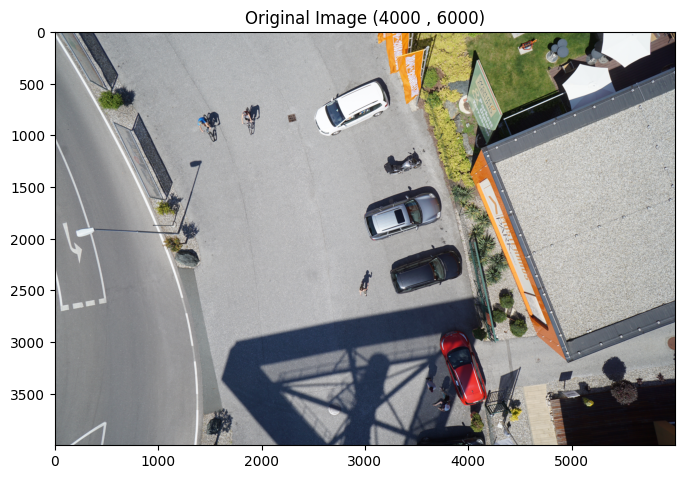

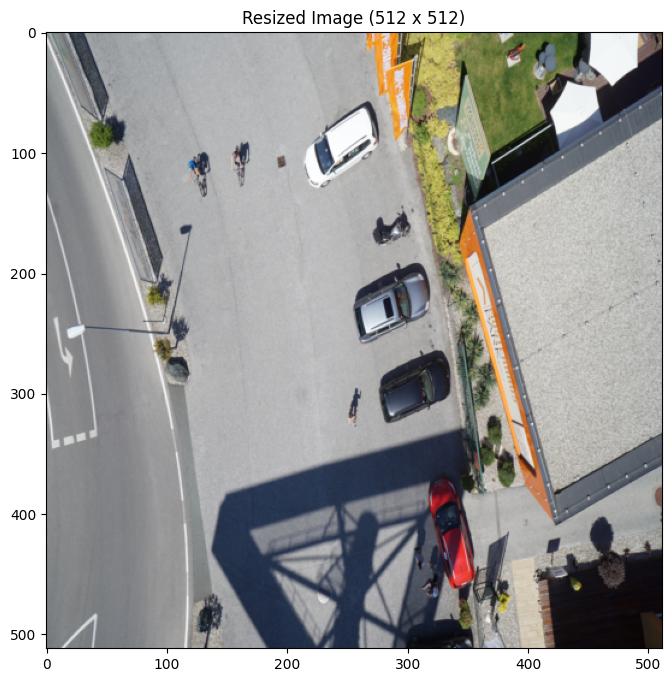

In [13]:
# Open the original image
image = Image.open(os.path.join(img_dir, train[0])).convert("RGB")

trans = transforms.Compose([
    transforms.Resize((512, 512))  # Use a smaller size to see the downsizing effect
])

# Apply the transformation
image_2 = trans(image)

image = np.array(image)
image_2 = np.array(image_2)

# Plot the original image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title("Original Image (4000 , 6000)")
plt.show()

# Plot the transformed (resized) image
plt.figure(figsize=(8, 8))
plt.imshow(image_2)
plt.title("Resized Image (512 x 512)")
plt.show()

In [9]:
#HYPERPARAMETERS
BATCH_SIZE = 4

In [7]:
train_dataset = Drone(parent_dir=parent_dir , 
                      images = train , 
                      masks = train_mask)

val_dataset = Drone(parent_dir=parent_dir , 
                      images = val , 
                      masks = val_mask)

test_dataset = Drone(parent_dir=parent_dir , 
                      images = test , 
                      masks = test_mask)

Index(['name', ' r', ' g', ' b'], dtype='object')
Index(['name', ' r', ' g', ' b'], dtype='object')
Index(['name', ' r', ' g', ' b'], dtype='object')


In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
len(train_loader) , len(test_loader) , len(val_loader)

(70, 15, 15)